In [1]:
import gc
import os
import sys
import math
import random
import warnings
import pickle
from pathlib import Path
from joblib import Parallel, delayed
from statsmodels.tsa.deterministic import (CalendarFourier,
                                           CalendarSeasonality,
                                           CalendarTimeTrend,
                                           DeterministicProcess)

from tqdm import tqdm
import os
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# from pandarallel import pandarallel
# pandarallel.initialize()
warnings.simplefilter("ignore")
import ctypes as ct
from datetime import timedelta

from sklearn.metrics import mean_absolute_error

import statistics as st
import lightgbm as lgbm
from scipy.stats import norm

In [2]:
sys.path.append('../../')
import src.utils as utils

## Param

In [3]:
EXP_NUM = 62
NFOLDS = 5
SEED = 42

In [4]:
targets_cols = ['playerId', 'target1', 'target2', 'target3', 'target4', 'date']
players_cols = ['playerId', 'primaryPositionName', 'birthCity', 'DOY', 'mlbDebutYear', 'DebutAge', 'heightInches', 'weight', 'playerForTestSetAndFuturePreds']
rosters_cols = ['playerId', 'teamId', 'status', 'date']
salaries_cols = ['teamId', 'salary', 'year']
standings_cols = ['teamId', 'wildCardRank', 'sportGamesBack', 'date']
transactions_cols = ['playerId', 'transaction_flag', 'date']
scores_cols = ['playerId', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances', 'date']

feature_cols1 = ['week_day','label_playerId', 'label_primaryPositionName', 'label_teamId',
       'label_status', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances',
        "target1_mean","target1_median","target1_std","target1_min","target1_max","target1_skew","target1_kurt",
         "target2_mean","target2_median","target2_std","target2_min","target2_max","target2_skew","target2_kurt",
        "target3_mean","target3_median","target3_std","target3_min","target3_max","target3_skew","target3_kurt",
        "target4_mean","target4_median","target4_std","target4_min","target4_max","target4_skew","target4_kurt", 
        'season_info', 'wildCardRank', 'label_awardName'] 

feature_cols2 = ['label_playerId', 'label_primaryPositionName', 'label_teamId',
       'label_status', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances',
        "target1_mean","target1_median","target1_std","target1_min","target1_max","target1_skew","target1_kurt",
         "target2_mean","target2_median","target2_std","target2_min","target2_max","target2_skew","target2_kurt",
        "target3_mean","target3_median","target3_std","target3_min","target3_max","target3_skew","target3_kurt",
        "target4_mean","target4_median","target4_std","target4_min","target4_max","target4_skew","target4_kurt", 
        'season_info', 'wildCardRank', 'label_awardName'] 

feature_cols3 = ['week_day','label_playerId', 'label_primaryPositionName', 'label_teamId',
       'label_status', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances',
        "target1_mean","target1_median","target1_std","target1_min","target1_max","target1_skew","target1_kurt",
         "target2_mean","target2_median","target2_std","target2_min","target2_max","target2_skew","target2_kurt",
        "target3_mean","target3_median","target3_std","target3_min","target3_max","target3_skew","target3_kurt",
        "target4_mean","target4_median","target4_std","target4_min","target4_max","target4_skew","target4_kurt", 
        'season_info', 'wildCardRank', 'label_awardName'] 

feature_cols4 = ['week_day', 'annual_day', 'month', 'label_playerId', 'label_primaryPositionName', 'label_teamId', 'label_birthCity',
                'DOY', 'mlbDebutYear', 'DebutAge', 'heightInches', 'weight',
       'label_status', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances',
        "target1_mean","target1_median","target1_std","target1_min","target1_max","target1_skew","target1_kurt",
         "target2_mean","target2_median","target2_std","target2_min","target2_max","target2_skew","target2_kurt",
        "target3_mean","target3_median","target3_std","target3_min","target3_max","target3_skew","target3_kurt",
        "target4_mean","target4_median","target4_std","target4_min","target4_max","target4_skew","target4_kurt", 
        'season_info', 'wildCardRank', 'label_awardName'] 

In [5]:
# training lightgbm
params1 = {
            'random_state': SEED,
            'objective':'mae',
            'n_estimators': 10000,
            'learning_rate': 0.1,
            'max_depth': 18,
            'min_child_weight': 8,
            'subsample': 0.9,
            'colsample_bytree': 0.5,
            'reg_lambda': 0.07770060902509043,
            'reg_alpha': 0.006917721077349456,
            'feature_fraction': 0.5448452017199268,
            'bagging_fraction': 0.9712581844886307,
            'bagging_freq': 17,
            'num_leaves': 757,
            'min_child_samples': 38
}


params2 = {
            'random_state': SEED,
            'objective':'mae',
            'n_estimators': 10000,
            'learning_rate': 0.1,
            'max_depth': 9,
            'min_child_weight': 19,
            'subsample': 0.7,
            'colsample_bytree': 0.5,
            'reg_lambda': 0.842789768469053,
            'reg_alpha': 0.002083027512061945,
            'feature_fraction': 0.6685585785820495,
            'bagging_fraction': 0.24812681263609027,
            'bagging_freq': 4,
            'num_leaves': 300,
            'min_child_samples': 88
}


params3 = {
            'random_state': SEED,
            'objective':'mae',
            'n_estimators': 10000,
            'learning_rate': 0.1,
            'max_depth': 6,
            'min_child_weight': 8,
            'subsample': 0.6,
            'colsample_bytree': 0.9,
            'reg_lambda': 0.20136897056918007,
            'reg_alpha': 0.12085385697554701,
            'feature_fraction': 0.9511894033022753,
            'bagging_fraction': 0.9078085686770417,
            'bagging_freq': 18,
            'num_leaves': 808,
            'min_child_samples': 35
}

params4 = {
            'random_state': SEED,
            'objective':'mae',
            'n_estimators': 10000,
            'learning_rate': 0.1,
            'max_depth': 16,
            'min_child_weight': 19,
            'subsample': 0.8,
            'colsample_bytree': 0.6,
            'reg_lambda': 0.9189086491671924,
            'reg_alpha': 85.91747956919798,
            'feature_fraction': 0.653862546945534,
            'bagging_fraction': 0.2539878828275932,
            'bagging_freq': 12,
            'num_leaves': 300,
            'min_child_samples': 92
}

In [6]:
utils.set_seed(SEED)

## Dir

In [7]:
DATA_DIR = Path("/home/knikaido/work/MLB-Player-Digital-Engagement-Forecasting/data/")
MAIN_DATA_DIR = DATA_DIR / 'mlb-player-digital-engagement-forecasting'
TRAIN_DIR = MAIN_DATA_DIR / 'train'
OUTPUT_DIR = Path('./output/')

In [8]:
players = pd.read_csv(MAIN_DATA_DIR / 'players.csv')

rosters = pd.read_csv(TRAIN_DIR / 'rosters_train.csv')
targets = pd.read_csv(TRAIN_DIR / 'nextDayPlayerEngagement_train.csv')
scores = pd.read_csv(TRAIN_DIR / 'playerBoxScores_train.csv')
scores = scores.groupby(['playerId', 'date']).sum().reset_index()
seasons = pd.read_csv(MAIN_DATA_DIR / 'seasons.csv')
salaries = pd.read_csv(MAIN_DATA_DIR / 'mlbSalaries.csv')
teams = pd.read_csv(MAIN_DATA_DIR / 'teams.csv')

standings = pd.read_csv(TRAIN_DIR / 'standings_train.csv')
awards = pd.read_csv(TRAIN_DIR / 'awards_train.csv')

playerTwitterFollowers = pd.read_csv(TRAIN_DIR / 'playerTwitterFollowers_train.csv')

# events = pd.read_csv(TRAIN_DIR / 'events_train.csv')
# events = events.groupby(['gameDate']).sum().reset_index()


In [9]:
awards

,awardId,awardName,awardDate,awardSeason,playerId,playerName,awardPlayerTeamId,index,date
0,VWLCPOY,VWL Comeback Player of the Year,2018-01-15,2017,150119,Freddy Garcia,699.0,14,20180115
1,VWLPOY,VWL Pitcher of the Year,2018-01-15,2017,446861,Guillermo Moscoso,699.0,14,20180115
2,VWLMOY,VWL Manager of the Year,2018-01-15,2017,492527,Mike Rojas,695.0,14,20180115
3,VWLRLOY,VWL Reliever of the Year,2018-01-15,2017,519246,Andres Santiago,694.0,14,20180115
4,VWLOPOY,VWL Offensive Player of the Year,2018-01-15,2017,543874,Jose Vargas,699.0,14,20180115
...,...,...,...,...,...,...,...,...,...
5910,NLPOM,NL Player of the Month,2021-04-30,2021,660670,Ronald Acuna Jr.,144.0,1215,20210430
5911,ALRRELMON,AL Reliever of the Month,2021-04-30,2021,598264,Matt Barnes,111.0,1215,20210430
5912,ALPOM,AL Player of the Month,2021-04-30,2021,621439,Byron Buxton,142.0,1215,20210430
5913,ALROM,AL Rookie of the Month,2021-04-30,2021,606213,Yermin Mercedes,145.0,1215,20210430


In [10]:
def map_team_name(name):
    names = name.split('-')
    result = ''
    for n in names:
        if n == 'st':
            n = 'st.'
        result += f' {n.capitalize()}'

    return result[1:]

salaries = salaries.groupby(['year', 'team']).sum()['salary'].reset_index()
salaries['team'] = salaries['team'].apply(map_team_name)
salaries = salaries.merge(teams, left_on='team', right_on='name', how='inner')
salaries = salaries.rename(columns={'id': 'teamId'})
salaries

,year,team,salary,teamId,name,teamName,teamCode,shortName,abbreviation,locationName,leagueId,leagueName,divisionId,divisionName,venueId,venueName
0,2019,Arizona Diamondbacks,62990590,109,Arizona Diamondbacks,D-backs,ari,Arizona,ARI,Phoenix,104,National League,203,National League West,15,Chase Field
1,2020,Arizona Diamondbacks,20167910,109,Arizona Diamondbacks,D-backs,ari,Arizona,ARI,Phoenix,104,National League,203,National League West,15,Chase Field
2,2021,Arizona Diamondbacks,52197674,109,Arizona Diamondbacks,D-backs,ari,Arizona,ARI,Phoenix,104,National League,203,National League West,15,Chase Field
3,2019,Atlanta Braves,115629465,144,Atlanta Braves,Braves,atl,Atlanta,ATL,Atlanta,104,National League,204,National League East,4705,Truist Park
4,2020,Atlanta Braves,50392877,144,Atlanta Braves,Braves,atl,Atlanta,ATL,Atlanta,104,National League,204,National League East,4705,Truist Park
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,2020,Toronto Blue Jays,33401637,141,Toronto Blue Jays,Blue Jays,tor,Toronto,TOR,Toronto,103,American League,201,American League East,14,Rogers Centre
86,2021,Toronto Blue Jays,104271393,141,Toronto Blue Jays,Blue Jays,tor,Toronto,TOR,Toronto,103,American League,201,American League East,14,Rogers Centre
87,2019,Washington Nationals,153637198,120,Washington Nationals,Nationals,was,Washington,WSH,Washington,104,National League,204,National League East,3309,Nationals Park
88,2020,Washington Nationals,45615023,120,Washington Nationals,Nationals,was,Washington,WSH,Washington,104,National League,204,National League East,3309,Nationals Park


In [11]:
seasons = seasons.fillna('0000-00-00')
for c_ in seasons.columns[1:]:
    seasons[c_] = seasons[c_].str.replace('-', '').astype(int)

In [12]:
seasons

,seasonId,seasonStartDate,seasonEndDate,preSeasonStartDate,preSeasonEndDate,regularSeasonStartDate,regularSeasonEndDate,lastDate1stHalf,allStarDate,firstDate2ndHalf,postSeasonStartDate,postSeasonEndDate
0,2017,20170402,20171101,20170222,20170401,20170402,20171001,20170709,20170711,20170714,20171003,20171101
1,2018,20180329,20181028,20180221,20180327,20180329,20181001,20180715,20180717,20180719,20181002,20181028
2,2019,20190320,20191030,20190221,20190326,20190320,20190929,20190707,20190709,20190711,20191001,20191030
3,2020,20200723,20201028,20200221,20200722,20200723,20200927,20200825,0,20200826,20200929,20201028
4,2021,20210228,20211031,20210228,20210330,20210401,20211003,20210711,20210713,20210715,20211004,20211031


In [13]:
targets_train = targets.merge(rosters[rosters_cols], on=['playerId', 'date'], how='left')

In [14]:
targets_train = targets_train[(targets_train['date'] >= 20210401)]

In [15]:
def calc_corr(df):
    # 相関係数行列を作成
    corr_mat = df.corr(method='pearson')

    # 行（列）サイズを取得
    n = corr_mat.shape[0]
    corr_ary = []

    for i in range(n):
        for j in range(i):
            if i == j:
                continue
            corr_ary.append(corr_mat.iloc[i,j])

    return corr_ary

In [16]:
playerId_list = targets_train['playerId'].unique()
len(playerId_list)

2061

In [17]:
def calc_probs(pid,df,temp):
    to_append=[pid,'','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','']
    targets=['target1','target2','target3','target4']
    z=1
    for target in targets:
        target_prob = temp[target].tolist()
        mean = np.mean(target_prob)
        std = np.std(target_prob)
        median = st.median(target_prob)
        distribution = norm(mean, std)
        min_weight = min(target_prob)
        max_weight = max(target_prob)
        values = list(np.linspace(min_weight, max_weight))
        probabilities = [distribution.pdf(v) for v in values]
        max_value = max(probabilities)
        max_index = probabilities.index(max_value)
        to_append[z]=mean
        to_append[z+1]=median
        to_append[z+2]=std
        to_append[z+3]=min_weight
        to_append[z+4]=max_weight
        to_append[z+5]=temp[target].skew()
        to_append[z+6]=temp[target].kurt()

        z=z+7
    corr_ = calc_corr(temp[['target1', 'target2', 'target3', 'target4']])
    to_append[z:] = corr_  
    df_length = len(df)
    df.loc[df_length] = to_append
    return df

    

### CREATE DATAFRAME to store probabilities
column_names = ["playerId", "target1_mean","target1_median","target1_std","target1_min","target1_max","target1_skew","target1_kurt",
                "target2_mean","target2_median","target2_std","target2_min","target2_max","target2_skew","target2_kurt",
                "target3_mean","target3_median","target3_std","target3_min","target3_max","target3_skew","target3_kurt",
                "target4_mean","target4_median","target4_std","target4_min","target4_max","target4_skew","target4_kurt",
                'tgt1_2_corr', 'tgt1_3_corr', 'tgt2_3_corr', 'tgt1_4_corr', 'tgt2_4_corr', 'tgt3_4_corr']
player_target_probs = pd.DataFrame(columns = column_names)
    
for pid in tqdm(playerId_list):
    temp = targets_train[targets_train['playerId'] == pid]
    player_target_stats=calc_probs(pid,player_target_probs,temp)

100%|██████████| 2061/2061 [00:45<00:00, 45.23it/s]


In [18]:
teamId_list = targets_train['teamId'].dropna().unique()
len(teamId_list)

30

In [19]:
team_target_probs = pd.DataFrame(columns = column_names)
    
for pid in tqdm(teamId_list):
    temp = targets_train[targets_train['teamId'] == pid]
    team_target_stats=calc_probs(pid,team_target_probs,temp)

100%|██████████| 30/30 [00:00<00:00, 42.31it/s]


In [20]:
c_ = list(team_target_stats.columns)
c_ = c_[:1] + ["team_" + word for word in c_[1:]]
team_target_stats.columns = c_

In [21]:
feature_cols1 += c_[1:]
feature_cols2 += c_[1:]
feature_cols3 += c_[1:]
feature_cols4 += c_[1:]

In [22]:
data_names=player_target_stats.columns.values.tolist()

In [23]:
players['DOY'] = pd.to_datetime(players['DOB'], format="%Y-%m-%d").dt.year
players['mlbDebutYear'] = pd.to_datetime(players['mlbDebutDate'], format="%Y-%m-%d").dt.year
players['DebutAge'] = players['mlbDebutYear'] - players['DOY']

In [24]:
# creat dataset
train = targets[targets_cols].merge(players[players_cols], on=['playerId'], how='left')
train = train.merge(rosters[rosters_cols], on=['playerId', 'date'], how='left')
train = train.merge(scores[scores_cols], on=['playerId', 'date'], how='left')
train = train.merge(player_target_stats, how='inner', left_on=["playerId"],right_on=["playerId"])
train = train.merge(standings[standings_cols], on=['teamId', 'date'], how='left')
train = train.merge(team_target_stats, how='left', left_on=["teamId"],right_on=["playerId"], suffixes=('', 'team_'))
train = train.merge(awards, on=['playerId', 'date'], how='left')


In [25]:
train

,playerId,target1,target2,target3,target4,date,primaryPositionName,birthCity,DOY,mlbDebutYear,...,team_tgt1_4_corr,team_tgt2_4_corr,team_tgt3_4_corr,awardId,awardName,awardDate,awardSeason,playerName,awardPlayerTeamId,index
0,628317,0.011167,4.474708,0.005168,5.735294,20180101,Pitcher,Osaka,1988,2016.0,...,0.313131,0.625082,0.298658,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,628317,0.006356,2.521008,0.001648,2.766917,20180102,Pitcher,Osaka,1988,2016.0,...,0.313131,0.625082,0.298658,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,628317,0.003556,2.380952,0.003624,3.439381,20180103,Pitcher,Osaka,1988,2016.0,...,0.313131,0.625082,0.298658,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,628317,0.003363,3.332367,0.012294,4.849601,20180104,Pitcher,Osaka,1988,2016.0,...,0.313131,0.625082,0.298658,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,628317,0.023976,1.440761,0.001501,2.371288,20180105,Pitcher,Osaka,1988,2016.0,...,0.313131,0.625082,0.298658,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2506246,656775,16.920553,13.339693,5.035756,4.136498,20210426,Outfielder,Greensboro,1994,2018.0,...,0.182149,0.511672,0.335373,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2506247,656775,1.779862,8.035688,0.287214,2.361922,20210427,Outfielder,Greensboro,1994,2018.0,...,0.182149,0.511672,0.335373,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2506248,656775,12.440696,17.293955,11.027232,4.128819,20210428,Outfielder,Greensboro,1994,2018.0,...,0.182149,0.511672,0.335373,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2506249,656775,10.765473,9.599092,7.968079,2.995182,20210429,Outfielder,Greensboro,1994,2018.0,...,0.182149,0.511672,0.335373,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
# label encoding
player2num = {c: i for i, c in enumerate(train['playerId'].unique())}
position2num = {c: i for i, c in enumerate(train['primaryPositionName'].unique())}
birthCityn2num = {c: i for i, c in enumerate(train['birthCity'].unique())}
teamid2num = {c: i for i, c in enumerate(train['teamId'].unique())}
status2num = {c: i for i, c in enumerate(train['status'].unique())}
status2num = {c: i for i, c in enumerate(train['status'].unique())}
awardName2num = {c: i for i, c in enumerate(train['awardName'].unique())}
train['label_playerId'] = train['playerId'].map(player2num)
train['label_primaryPositionName'] = train['primaryPositionName'].map(position2num)
train['label_birthCity'] = train['birthCity'].map(birthCityn2num)
train['label_teamId'] = train['teamId'].map(teamid2num)
train['label_status'] = train['status'].map(status2num)
train['label_awardName'] = train['awardName'].map(awardName2num)
train['label_awardName'] = (train['label_awardName'] != 0) * 1

In [27]:
date_ = pd.to_datetime(train['date'], format="%Y%m%d")
train['annual_day'] = (date_ - pd.to_datetime(date_.dt.year, format="%Y")) /  timedelta(days=1)
train['week_day'] = date_.dt.weekday
train['month'] = date_.dt.month
train['year'] = date_.dt.year

In [28]:
# train = train.merge(salaries[salaries_cols], how='left', on=["teamId", 'year'])
train = train.merge(playerTwitterFollowers, how='left', on=["playerId", 'date'])

## game info

In [29]:
train['gameday'] = ~train['battingOrder'].isna()*1

In [30]:
train.sort_values(by=['playerId','date'],inplace=True,ascending=True)

In [31]:
def count_consecutive_items_n_cols(df, col_name_list, output_col):
    cum_sum_list = [
        (df[col_name] != df[col_name].shift(1)).cumsum().tolist() for col_name in col_name_list
    ]
    df[output_col] = df.groupby(
        ["_".join(map(str, x)) for x in zip(*cum_sum_list)]
    ).cumcount() + 1
    return df

In [32]:
train=count_consecutive_items_n_cols(train,['playerId','gameday'],'daysSinceLastGame')
train.loc[train['gameday']==1,'daysSinceLastGame']=0

In [33]:
train_game = train[train['gameday']==1]
train_last_game = train_game[~train_game.duplicated(subset='playerId', keep='last')][['playerId', 'date']]
train_last_game.columns = ['playerId', 'lastdate']
train_player_unique = pd.DataFrame(train['playerId'].unique(), columns=['playerId'])
train_last_game = pd.merge(train_player_unique, train_last_game, on=['playerId'], how='left' )
train_last_game = train_last_game.fillna(20171231)

In [34]:
train_last_game.sort_values('lastdate')

,playerId,lastdate
856,593590,20171231.0
1995,670462,20171231.0
2000,670764,20171231.0
1765,661269,20171231.0
1932,667674,20171231.0
...,...,...
473,542932,20210430.0
1480,641856,20210430.0
1481,641857,20210430.0
483,543037,20210430.0


## Season info

In [35]:
def extract_season(date_raw, season_start_end):
    idxes = 0
    for raw in season_start_end.iloc():
        idx_ = ((date_raw >= raw.iloc[0]) & (date_raw <= raw.iloc[1])) * 1
        idxes += idx_
    return idxes

In [36]:
on_preseason_idxes = extract_season(train['date'], seasons[['preSeasonStartDate', 'preSeasonEndDate']])
on_season_idxes = extract_season(train['date'], seasons[['regularSeasonStartDate', 'regularSeasonEndDate']]) * 2
on_postseason_idxes = extract_season(train['date'], seasons[['postSeasonStartDate', 'postSeasonEndDate']]) * 3

special_days = seasons['lastDate1stHalf'].to_list() + seasons['allStarDate'].to_list() + seasons['firstDate2ndHalf'].to_list()
special_idxes = 0
for day in special_days:
    special_idxes += (train['date'] == day) * 4

on_total_season_idxes = on_preseason_idxes
on_total_season_idxes[on_season_idxes==2] = 2
on_total_season_idxes[on_postseason_idxes==3] = 3
on_total_season_idxes[special_idxes==4] = 4

train['season_info'] = on_total_season_idxes

In [37]:
## only on season
on_whole_idxes = extract_season(train['date'], seasons[['seasonStartDate', 'seasonEndDate']])
train = train[on_whole_idxes == 1].reset_index(drop=True)

In [38]:
train = train[train['playerForTestSetAndFuturePreds']==True].reset_index(drop=True)

In [39]:
train

,playerId,target1,target2,target3,target4,date,primaryPositionName,birthCity,DOY,mlbDebutYear,...,month,year,playerName_y,accountName,twitterHandle,numberOfFollowers,index_y,gameday,daysSinceLastGame,season_info
0,405395,1.916353,21.512858,0.078997,7.389917,20180329,First Base,Santo Domingo,1980,2001.0,...,3,2018,NaN,NaN,NaN,NaN,NaN,1,0,2
1,405395,2.431219,38.280184,0.080521,10.307364,20180330,First Base,Santo Domingo,1980,2001.0,...,3,2018,NaN,NaN,NaN,NaN,NaN,1,0,2
2,405395,4.890499,18.149785,0.196634,19.190820,20180331,First Base,Santo Domingo,1980,2001.0,...,3,2018,NaN,NaN,NaN,NaN,NaN,1,0,2
3,405395,0.061685,21.539123,0.215855,28.610586,20180401,First Base,Santo Domingo,1980,2001.0,...,4,2018,Albert Pujols,Albert Pujols,@pujolsfive,201230.0,90.0,1,0,2
4,405395,0.021304,19.234421,0.217329,20.419970,20180402,First Base,Santo Domingo,1980,2001.0,...,4,2018,NaN,NaN,NaN,NaN,NaN,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
711059,685503,0.044617,1.224728,0.009437,0.737463,20210426,Pitcher,Hiroshima,1992,2021.0,...,4,2021,NaN,NaN,NaN,NaN,NaN,0,1,2
711060,685503,0.019123,1.178880,0.013161,0.790301,20210427,Pitcher,Hiroshima,1992,2021.0,...,4,2021,NaN,NaN,NaN,NaN,NaN,0,2,2
711061,685503,0.015799,4.323489,0.002350,0.970273,20210428,Pitcher,Hiroshima,1992,2021.0,...,4,2021,NaN,NaN,NaN,NaN,NaN,0,3,2
711062,685503,0.018770,31.946021,0.305491,5.938273,20210429,Pitcher,Hiroshima,1992,2021.0,...,4,2021,NaN,NaN,NaN,NaN,NaN,0,4,2


## train

In [40]:
def fit_lgbm(x_train, y_train, x_valid, y_valid, params: dict=None, verbose=100):
    oof_pred = np.zeros(len(y_valid), dtype=np.float32)
    model = lgbm.LGBMRegressor(**params)
    model.fit(x_train, y_train, 
        eval_set=[(x_valid, y_valid)],  
        early_stopping_rounds=verbose, 
        verbose=verbose)
    oof_pred = model.predict(x_valid)
    oof_pred = np.clip(oof_pred, 0, 100)
    score = mean_absolute_error(oof_pred, y_valid)
    print('mae:', score)
    return oof_pred, model, score


In [41]:
train_X = train
train_y = train[['target1', 'target2', 'target3', 'target4']]
tr_idxs = []
val_idxs = []

In [42]:
tr_idx = (train['date'].astype(int) < 20200801)
val_idx = (train['date'].astype(int) >= 20200801) & (train['date'].astype(int) < 20200901)
tr_idxs.append(tr_idx)
val_idxs.append(val_idx)

tr_idx = (train['date'].astype(int) < 20200901)
val_idx = (train['date'].astype(int) >= 20200901) & (train['date'].astype(int) < 20201001)
tr_idxs.append(tr_idx)
val_idxs.append(val_idx)

tr_idx = (train['date'].astype(int) < 20201001)
val_idx = (train['date'].astype(int) >= 20201001) & (train['date'].astype(int) < 20201028)
tr_idxs.append(tr_idx)
val_idxs.append(val_idx)

tr_idx = (train['date'].astype(int) < 20210228)
val_idx = (train['date'].astype(int) >= 20210228) & (train['date'].astype(int) < 20210401)
tr_idxs.append(tr_idx)
val_idxs.append(val_idx)

tr_idx = (train['date'].astype(int) < 20210401)
val_idx = ~tr_idx
tr_idxs.append(tr_idx)
val_idxs.append(val_idx)

In [43]:
model1s = []
model2s = []
model3s = []
model4s = []
oof = np.zeros(train_y.shape) - 1.0
y_valids = np.zeros(train_y.shape) - 1.0

for idx in range(NFOLDS):
    
    tr_idx = tr_idxs[idx]
    val_idx = val_idxs[idx]

    x_train = train_X.loc[tr_idx].reset_index(drop=True)
    y_train = train_y.loc[tr_idx].reset_index(drop=True)
    x_valid = train_X.loc[val_idx].reset_index(drop=True)
    y_valid = train_y.loc[val_idx].reset_index(drop=True)


    oof1, model1, score1 = fit_lgbm(
        x_train[feature_cols1], y_train['target1'],
        x_valid[feature_cols1], y_valid['target1'],
        params1
    )
    oof2, model2, score2 = fit_lgbm(
        x_train[feature_cols2], y_train['target2'],
        x_valid[feature_cols2], y_valid['target2'],
        params2
    )
    oof3, model3, score3 = fit_lgbm(
        x_train[feature_cols3], y_train['target3'],
        x_valid[feature_cols3], y_valid['target3'],
        params3
    )
    oof4, model4, score4 = fit_lgbm(
        x_train[feature_cols4], y_train['target4'],
        x_valid[feature_cols4], y_valid['target4'],
        params4
    )

    score = (score1+score2+score3+score4) / 4
    print(f'score: {score}')
    
    model1s.append(model1)
    model2s.append(model2)
    model3s.append(model3)
    model4s.append(model4)
    oof[val_idx, 0] = oof1
    oof[val_idx, 1] = oof2
    oof[val_idx, 2] = oof3
    oof[val_idx, 3] = oof4
    y_valids[val_idx, 0] = y_valid['target1'].values
    y_valids[val_idx, 1] = y_valid['target2'].values
    y_valids[val_idx, 2] = y_valid['target3'].values
    y_valids[val_idx, 3] = y_valid['target4'].values
    


[LightGBM] [Warning] feature_fraction is set=0.5448452017199268, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.5448452017199268
[LightGBM] [Warning] bagging_fraction is set=0.9712581844886307, subsample=0.9 will be ignored. Current value: bagging_fraction=0.9712581844886307
[LightGBM] [Warning] bagging_freq is set=17, subsample_freq=0 will be ignored. Current value: bagging_freq=17
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 0.867347
Early stopping, best iteration is:
[24]	valid_0's l1: 0.848844
mae: 0.8488296771955494
[LightGBM] [Warning] feature_fraction is set=0.6685585785820495, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.6685585785820495
[LightGBM] [Warning] bagging_fraction is set=0.24812681263609027, subsample=0.7 will be ignored. Current value: bagging_fraction=0.24812681263609027
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


In [44]:
oof_indexes = []
for i in range(NFOLDS):
    oof_indexes.extend(val_idxs[i][val_idxs[i]==True].index.to_list())

In [45]:
y_valids[val_idx, :]
mae = mean_absolute_error(y_valids[oof_indexes, :], oof[oof_indexes, :])
print("mae:", mae)

mae: 1.4842774401378713


In [46]:
oof_df = train[targets_cols]
oof_df.iloc[oof_indexes, 1:5] = oof[oof_indexes, :]

In [47]:
oof_df.iloc[oof_indexes].to_csv(OUTPUT_DIR / f'oof{EXP_NUM}.csv')

In [48]:
models = np.array([model1s, model2s, model3s, model4s])
with open(OUTPUT_DIR / f"models{EXP_NUM}.pickle", mode="wb") as f:
    pickle.dump(models, f)

In [49]:
weights = [0.05, 0.1, 0.15, 0.2, 0.5]

In [50]:
pred1s = 0
pred2s = 0
pred3s = 0
pred4s = 0
for i in range(NFOLDS):
    pred1 = models[0][i].predict(x_valid[feature_cols1])
    pred2 = models[1][i].predict(x_valid[feature_cols2])
    pred3 = models[2][i].predict(x_valid[feature_cols3])
    pred4 = models[3][i].predict(x_valid[feature_cols4])
    oof_valid_april = np.clip(np.array([pred1, pred2, pred3, pred4]).T, 0, 100)
    mae = mean_absolute_error(y_valid, oof_valid_april)
    print("mae:", mae)
    pred1s += pred1 * weights[i]
    pred2s += pred2 * weights[i]
    pred3s += pred3 * weights[i]
    pred4s += pred4 * weights[i]

mae: 1.518360100503496
mae: 1.5113414639957996
mae: 1.499455811988903
mae: 1.5130507457270528
mae: 1.479132668658858


In [51]:
oof_valid_april = np.clip(np.array([pred1s, pred2s, pred3s, pred4s]).T, 0, 100)

In [52]:
# oof_valid_april = np.where(oof_valid_april < 0.1, 0, oof_valid_april)

In [53]:
mae = mean_absolute_error(y_valid, oof_valid_april)
print("mae:", mae)

mae: 1.4837855481494464


In [54]:
mae: 1.500707591815054

mae: 1.4922717960190015
mae: 1.4932996706084116


## EDA pred

In [58]:
# import eli5
# from eli5.sklearn import PermutationImportance

# perm = PermutationImportance(model1, random_state=SEED).fit(x_valid[feature_cols1],y_valid['target1'])
# eli5.show_weights(perm, feature_names = x_valid[feature_cols1].columns.tolist(), top=200)

In [46]:
importance = pd.DataFrame(model1.feature_importances_, index=feature_cols1, columns=['importance'])
importance = importance.sort_values('importance', ascending=False)
importance.iloc[0:30].index

Index(['label_playerId', 'season_info', 'target1_mean', 'wildCardRank',
       'target1_skew', 'target2_skew', 'target4_min', 'label_teamId',
       'target2_mean', 'target4_median', 'target2_median', 'target3_skew',
       'target4_mean', 'target4_skew', 'target3_mean', 'target2_kurt',
       'target2_min', 'label_status', 'target1_std', 'target2_std',
       'label_primaryPositionName', 'target1_kurt', 'target1_median',
       'target4_std', 'target4_kurt', 'target1_max', 'target3_kurt',
       'target3_median', 'target4_max', 'target3_std'],
      dtype='object')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

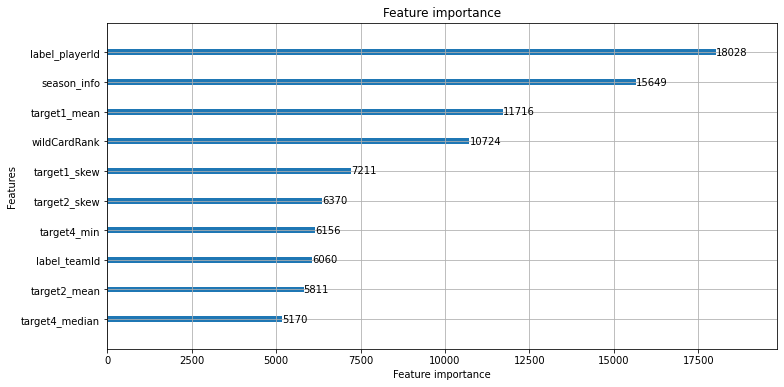

In [47]:
lgbm.plot_importance(model1, figsize=(12, 6), max_num_features=10)

In [48]:
importance = pd.DataFrame(model2.feature_importances_, index=feature_cols2, columns=['importance'])
importance = importance.sort_values('importance', ascending=False)
importance.iloc[:30].index

Index(['season_info', 'target4_min', 'label_status', 'label_teamId',
       'label_playerId', 'target2_min', 'target4_median', 'target2_median',
       'target2_mean', 'target1_mean', 'target2_max',
       'label_primaryPositionName', 'wildCardRank', 'target2_std',
       'target4_mean', 'target3_min', 'target4_std', 'target4_skew',
       'target1_std', 'target3_mean', 'totalBases', 'target4_max',
       'plateAppearances', 'target1_min', 'target1_median', 'battingOrder',
       'target4_kurt', 'target2_skew', 'winsPitching', 'rbi'],
      dtype='object')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

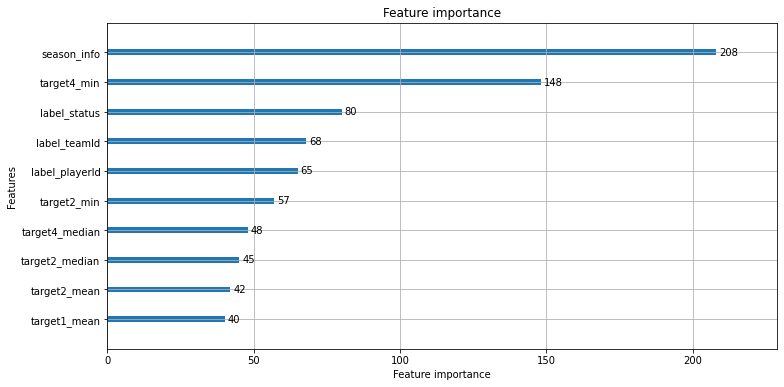

In [49]:
lgbm.plot_importance(model2, figsize=(12, 6), max_num_features=10)

In [50]:
importance = pd.DataFrame(model3.feature_importances_, index=feature_cols3, columns=['importance'])
importance = importance.sort_values('importance', ascending=False)
importance.iloc[:30].index

Index(['label_teamId', 'target2_median', 'label_playerId', 'target4_min',
       'target3_skew', 'target4_median', 'target2_skew', 'target4_mean',
       'target1_mean', 'target2_min', 'target4_skew', 'target1_std',
       'target2_std', 'target4_std', 'target1_skew', 'target1_kurt',
       'target2_mean', 'target3_mean', 'target2_kurt', 'target3_max',
       'target3_median', 'target2_max', 'target3_std', 'target3_kurt',
       'season_info', 'target1_median', 'target1_min', 'target3_min',
       'target4_kurt', 'target4_max'],
      dtype='object')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

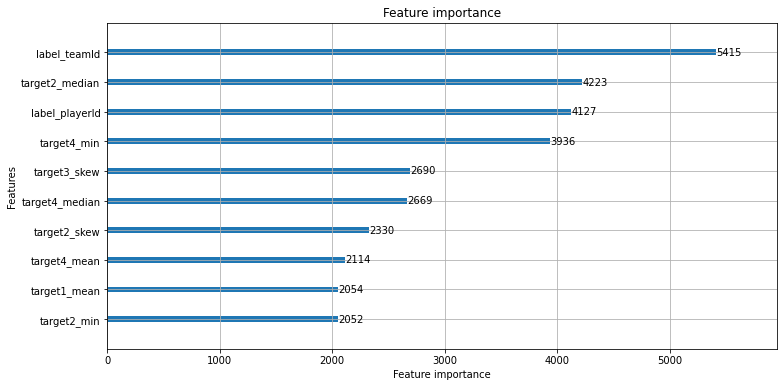

In [51]:
lgbm.plot_importance(model3, figsize=(12, 6), max_num_features=10)

In [52]:
importance = pd.DataFrame(model4.feature_importances_, index=feature_cols4, columns=['importance'])
importance = importance.sort_values('importance', ascending=False)
importance.iloc[:30].index

Index(['annual_day', 'target4_median', 'target4_min', 'label_playerId',
       'week_day', 'target4_mean', 'DOY', 'label_teamId', 'label_birthCity',
       'target2_mean', 'month', 'target2_skew', 'weight', 'target2_min',
       'mlbDebutYear', 'target2_std', 'target2_median', 'label_status',
       'target2_kurt', 'DebutAge', 'target4_skew', 'target1_skew',
       'target4_kurt', 'season_info', 'target1_mean', 'target1_kurt',
       'target4_std', 'wildCardRank', 'target3_mean', 'target3_skew'],
      dtype='object')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

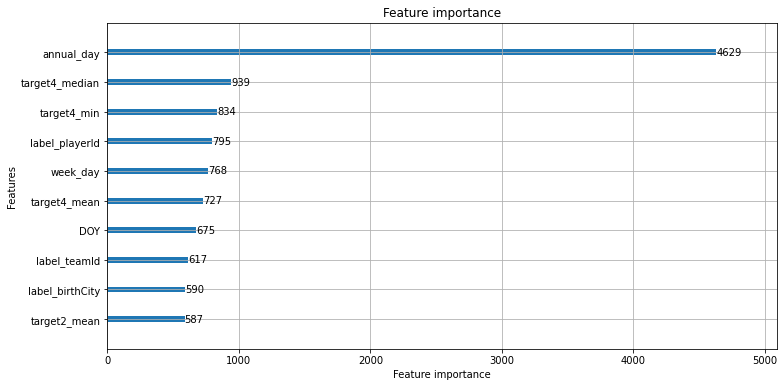

In [53]:
lgbm.plot_importance(model4, figsize=(12, 6), max_num_features=10)

## テストで取ってこれる一行はこんな感じ

In [33]:
example_sample_submission = pd.read_csv(MAIN_DATA_DIR / "example_sample_submission.csv")
example_test = pd.read_csv(MAIN_DATA_DIR / "example_test.csv")
test_df = example_test.set_index('date').iloc[:1]
sample_prediction_df = example_sample_submission[example_sample_submission['date']==test_df.index[0]].set_index('date')

In [34]:
players_cols = ['playerId', 'primaryPositionName', 'birthCity', 'DOY', 'mlbDebutYear', 'DebutAge', 'heightInches', 'weight']
rosters_cols = ['playerId', 'teamId', 'status']
scores_cols = ['playerId', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances']

null = np.nan
true = True
false = False

# env = mlb.make_env() # initialize the environment
# iter_test = env.iter_test() # iterator which loops over each date in test set

# for (test_df, sample_prediction_df) in iter_test: # make predictions here
    
sample_prediction_df = sample_prediction_df.reset_index(drop=True)

# creat dataset
sample_prediction_df['playerId'] = sample_prediction_df['date_playerId']\
                                    .map(lambda x: int(x.split('_')[1]))
# Dealing with missing values
if test_df['rosters'].iloc[0] == test_df['rosters'].iloc[0]:
    test_rosters = pd.DataFrame(eval(test_df['rosters'].iloc[0]))
else:
    test_rosters = pd.DataFrame({'playerId': sample_prediction_df['playerId']})
    for col in rosters.columns:
        if col == 'playerId': continue
        test_rosters[col] = np.nan

if test_df['playerBoxScores'].iloc[0] == test_df['playerBoxScores'].iloc[0]:
    test_scores = pd.DataFrame(eval(test_df['playerBoxScores'].iloc[0]))
else:
    test_scores = pd.DataFrame({'playerId': sample_prediction_df['playerId']})
    for col in scores.columns:
        if col == 'playerId': continue
        test_scores[col] = np.nan
test_scores = test_scores.groupby('playerId').sum().reset_index()
test = sample_prediction_df[['playerId']].copy()
test = test.merge(players[players_cols], on='playerId', how='left')
test = test.merge(test_rosters[rosters_cols], on='playerId', how='left')
test = test.merge(test_scores[scores_cols], on='playerId', how='left')
test = test.merge(player_target_stats, how='inner', left_on=["playerId"],right_on=["playerId"])


test['label_playerId'] = test['playerId'].map(player2num)
test['label_primaryPositionName'] = test['primaryPositionName'].map(position2num)
test['label_teamId'] = test['teamId'].map(teamid2num)
test['label_status'] = test['status'].map(status2num)
test['label_birthCity'] = test['birthCity'].map(birthCityn2num)

date_ = pd.to_datetime(test_df.index[0], format="%Y%m%d")
test['annual_day'] = (date_ - pd.to_datetime(date_.year, format="%Y")) /  timedelta(days=1)
test['week_day'] = date_.weekday()
test['month'] = date_.month


test_X = test

In [35]:
test_X['gameday'] = ~test_X['battingOrder'].isna()*1
test_X['date'] = test_df.index[0]
test_X = pd.merge(test_X, train_last_game, on=['playerId'], how='left')
test_X['daysSinceLastGame'] = (pd.to_datetime(test_X['date'], format="%Y%m%d") - pd.to_datetime(test_X['lastdate'], format="%Y%m%d")).dt.days
test_X.loc[test_X['gameday']==1,'daysSinceLastGame']=0

In [59]:
train_last_game = pd.merge(train_last_game, test_X[test_X['gameday']==1][['playerId','date']], on=['playerId'], how='left')
train_last_game['lastdate'].update(train_last_game['date'])
train_last_game = train_last_game[['playerId', 'lastdate']]
train_last_game

,playerId,lastdate
0,112526,20180922.0
1,134181,20180930.0
2,279571,20180930.0
3,282332,20191017.0
4,400085,20190321.0
...,...,...
2056,681911,20210426.0
2057,683232,20210426.0
2058,683734,20210426.0
2059,685493,20200927.0


In [54]:
# predict
pred1 = model1.predict(test_X[feature_cols1])
pred2 = model2.predict(test_X[feature_cols2])
pred3 = model3.predict(test_X[feature_cols3])
pred4 = model4.predict(test_X[feature_cols4])

# merge submission
sample_prediction_df['target1'] = np.clip(pred1, 0, 100)
sample_prediction_df['target2'] = np.clip(pred2, 0, 100)
sample_prediction_df['target3'] = np.clip(pred3, 0, 100)
sample_prediction_df['target4'] = np.clip(pred4, 0, 100)
sample_prediction_df = sample_prediction_df.fillna(0.)

del sample_prediction_df['playerId']

In [55]:
sample_prediction_df

,date_playerId,target1,target2,target3,target4
0,20210427_656669,4.523566,7.302453,2.559227e-01,2.723813
1,20210427_543475,0.147992,3.124557,2.008687e-01,1.193542
2,20210427_592866,0.006262,1.240768,1.289277e-02,1.045266
3,20210427_452678,0.028216,3.628774,4.949686e-02,1.776316
4,20210427_570257,0.008472,1.085709,1.132856e-02,0.437531
...,...,...,...,...,...
1182,20210427_593590,0.000010,0.013661,1.073450e-18,0.000000
1183,20210427_642180,0.002000,1.000161,3.896596e-03,0.397934
1184,20210427_663399,0.000242,0.336076,1.736459e-03,0.087545
1185,20210427_664199,0.000847,0.919104,5.898664e-03,0.507688
